In [1]:
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib

clear_output()

In [ ]:
nu = 1  # 制御入力の次元
nx = 2  # 状態変数の次元

# コスト関数の重み
Q = casadi.diag([100, 1])
Q_f = casadi.diag([100, 1])
R = casadi.diag([0.01])

# 予測ホライズン等
T = 5
K = 10
dt = T / K

# 制約条件
x_lb = [-np.inf, -np.inf]
x_ub = [np.inf, np.inf]
u_lb = [-np.inf]
u_ub = [np.inf]

total = nx * (K + 1) + nu * K

In [ ]:
damper_coeff = 50


def make_f():
    states = casadi.SX.sym("states", nx)
    ctrls = casadi.SX.sym("ctrls", nu)

    x1 = states[0]
    x2 = states[1]
    u = ctrls[0]

    x1_dot = x2
    x2_dot = -damper_coeff * x2 - x1 + u

    states_dot = casadi.vertcat(x1_dot, x2_dot)

    f = casadi.Function("f", [states, ctrls], [states_dot], ["x", "u"], ["x_dot"])
    return f


def make_ModifiedEuler():
    states = casadi.SX.sym("states", nx)
    ctrls = casadi.SX.sym("ctrls", nu)

    f = make_f()

    r1 = f(x=states, u=ctrls)["x_dot"]
    r2 = f(x=states + dt * r1, u=ctrls)["x_dot"]
    states_next = states + dt * (r1 + r2) / 2  # 2nd order runge-kutta method.

    return casadi.Function(
        "ModifiedEuler", [states, ctrls], [states_next], ["x", "u"], ["x_next"]
    )


def make_integrator():
    states = casadi.SX.sym("states", nx)
    ctrls = casadi.SX.sym("ctrls", nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x": states, "p": ctrls, "ode": ode}

    I = casadi.integrator("I", "cvodes", dae, 0, dt)
    return I


def compute_stage_cost(x, u):
    cost = (casadi.dot(Q @ x, x) + casadi.dot(R @ u, u)) / 2
    return cost


def compute_terminal_cost(x):
    cost = casadi.dot(Q_f @ x, x) / 2
    return cost

In [ ]:
d = 2

A = np.zeros((d, d))
b = np.zeros(d)
c = casadi.collocation_points(d, "legendre")
for j in range(d):
    lj = 1
    for l in range(d):
        if l != j:
            lj *= np.poly1d([1, -c[l]]) / (
                c[j] - c[l]
            )  # estimate D and beta in collocation method.
    lj_int = np.polyint(lj)
    b[j] = lj_int(1) - lj_int(0)
    for i in range(d):
        A[i, j] = lj_int(c[i]) - lj_int(0)
D = np.linalg.inv(A)
beta = D.T @ b

In [ ]:
print("A", A)
print("b", b)
print("c", c)
print("D", D)
print("beta", beta)

A [[ 0.25       -0.03867513]
 [ 0.53867513  0.25      ]]
b [0.5 0.5]
c [0.21132486540518713, 0.7886751345948129]
D [[ 3.          0.46410162]
 [-6.46410162  3.        ]]
beta [-1.73205081  1.73205081]


In [ ]:
def make_nlp_dc():
    f = make_f()

    U = [casadi.SX.sym(f"u_{k}", nu) for k in range(K)]
    X = [casadi.SX.sym(f"x_{k}", nx) for k in range(K + 1)]
    Xc = []
    for k in range(K):
        for j in range(d):
            Xc.append(casadi.SX.sym(f"x_{k}_{j}", nx))

    G = []
    J = 0
    for k in range(K):
        Xk_end = 1 * X[k]
        for j in range(d):
            xp = 0
            for r in range(d):
                xp = xp + D[j, r] * (Xc[k * d + r] - X[k])
            fj = f(Xc[k * d + j], U[k])
            Xk_end = Xk_end + beta[j] * Xc[k * d + j]
            J = J + dt * b[j] * compute_stage_cost(Xc[k * d + j], U[k])
            G.append(dt * fj - xp)
        G.append(Xk_end - X[k + 1])

    J += compute_terminal_cost(X[-1])
    option = {"print_time": False, "ipopt": {"print_level": 0}}
    nlp = {"x": casadi.vertcat(*X, *Xc, *U), "f": J, "g": casadi.vertcat(*G)}
    S = casadi.nlpsol("S", "ipopt", nlp, option)
    return S

In [ ]:
def compute_optimal_control_dc(S_dc, x_init, x0_dc):
    x_init = x_init.full().ravel().tolist()

    lbx = x_init + x_lb * K * (1 + d) + u_lb * K
    ubx = x_init + x_ub * K * (1 + d) + u_ub * K
    lbg = [0] * nx * K * (1 + d)
    ubg = [0] * nx * K * (1 + d)

    res = S_dc(lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, x0=x0_dc)

    offset = nx + nx * K * (1 + d)
    x0_dc = res["x"]
    u_opt = x0_dc[offset : offset + nu]
    return u_opt, x0_dc

In [8]:
S_dc = make_nlp_dc()

In [ ]:
def make_nlp():
    F_ModifiedEuler = make_ModifiedEuler()

    U = [casadi.SX.sym(f"u_{k}", nu) for k in range(K)]
    X = [casadi.SX.sym(f"x_{k}", nx) for k in range(K + 1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k], U[k]) * dt
        eq = X[k + 1] - F_ModifiedEuler(x=X[k], u=U[k])["x_next"]
        G.append(eq)  # transition function. -> equality constraint.
    J += compute_terminal_cost(X[-1])

    option = {"print_time": False, "ipopt": {"print_level": 0}}
    nlp = {"x": casadi.vertcat(*X, *U), "f": J, "g": casadi.vertcat(*G)}
    S = casadi.nlpsol("S", "ipopt", nlp, option)
    return S

In [ ]:
def compute_optimal_control(S, x_init, x0):
    x_init = x_init.full().ravel().tolist()

    lbx = x_init + x_lb * K + u_lb * K
    ubx = x_init + x_ub * K + u_ub * K
    lbg = [0] * nx * K
    ubg = [0] * nx * K

    res = S(lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, x0=x0)

    offset = nx * (K + 1)
    x0 = res["x"]
    u_opt = x0[offset : offset + nu]
    return u_opt, x0

In [13]:
S = make_nlp()

In [ ]:
x_init = casadi.DM([1, 1])

# Direct Collocation Method
x0_dc = casadi.DM.zeros(nx + nx * K * (1 + d) + nu * K)
u_opt, x0_dc = compute_optimal_control_dc(S_dc, x_init, x0_dc)

# Direct Multiple Shooting Method
x0_dms = casadi.DM.zeros(total)
u_opt, x0_dms = compute_optimal_control(S, x_init, x0_dms)

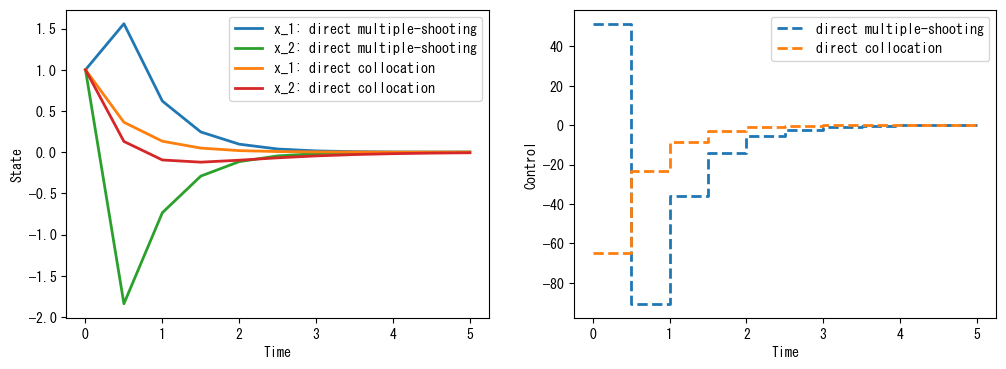

In [ ]:
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]


dms_data_x1 = x0_dms[: nx * (K + 1)][::nx].toarray().flatten()
dc_data_x1 = x0_dc[: nx * (K + 1)][::nx].toarray().flatten()
dms_data_x2 = x0_dms[1 : nx * (K + 1) + 1][::nx].toarray().flatten()
dc_data_x2 = x0_dc[1 : nx * (K + 1) + 1][::nx].toarray().flatten()
dms_data_u = x0_dms[nx * (K + 1) :].toarray().flatten()
dc_data_u = x0_dc[nx + nx * K * (1 + d) :].toarray().flatten()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(
    dt * np.array(range(K + 1)),
    dms_data_x1,
    color=cycle[0],
    linewidth=2,
    label="x_1: direct multiple-shooting",
)
plt.plot(
    dt * np.array(range(K + 1)),
    dms_data_x2,
    color=cycle[2],
    linewidth=2,
    label="x_2: direct multiple-shooting",
)
plt.plot(
    dt * np.array(range(K + 1)),
    dc_data_x1,
    color=cycle[1],
    linewidth=2,
    label="x_1: direct collocation",
)
plt.plot(
    dt * np.array(range(K + 1)),
    dc_data_x2,
    color=cycle[3],
    linewidth=2,
    label="x_2: direct collocation",
)
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()

plt.subplot(1, 2, 2)
plt.step(
    dt * np.array(range(K + 1)),
    np.hstack([dms_data_u[0], dms_data_u]),
    "--",
    color=cycle[0],
    linewidth=2,
    label="direct multiple-shooting",
)
plt.step(
    dt * np.array(range(K + 1)),
    np.hstack([dc_data_u[0], dc_data_u]),
    "--",
    color=cycle[1],
    linewidth=2,
    label="direct collocation",
)
plt.xlabel("Time")
plt.ylabel("Control")
plt.legend()

# plt.savefig("images/chap6_collocation_stiff_equation.pdf")
plt.savefig("images/chap6_collocation_stiff_equation.png")

In [14]:
# # 解のprint
# print(dms_data_x1)
# print(dms_data_u)
# print(dc_data_x1)
# print(dc_data_u)

In [15]:
# # 厳密に積分

# lam1 = -damper_coeff/2 + np.sqrt((damper_coeff**2) -4)/2
# lam2 = -damper_coeff/2 - np.sqrt((damper_coeff**2) -4)/2
# print(lam1,lam2)
# mat = np.linalg.inv(np.array([[1,1],[lam1,lam2]]))
# def F_exact(x, u):
#     coef = mat @ np.array([x[0]-u,x[1]])
#     x1_next = coef[0]*np.exp(lam1*dt)+u
#     x2_next = coef[1]*np.exp(lam2*dt)
#     return np.array([x1_next,x2_next])

# tmp_x = x0_dms[:2].toarray().flatten()
# for i in range(len(dms_data_u)):
#     print(tmp_x,dms_data_u[i])
#     tmp_x = F_exact(tmp_x, dms_data_u[i])

# tmp_x = x0_dc[:2].toarray().flatten()
# for i in range(len(dc_data_u)):
#     print(tmp_x,dc_data_u[i])
#     tmp_x = F_exact(tmp_x, dc_data_u[i])

In [16]:
# # 修正オイラー法で積分
# F_ModifiedEuler = make_ModifiedEuler()

# tmp_x = x0_dms[:2].toarray().flatten()
# for i in range(len(dms_data_u)):
#     print(tmp_x,dms_data_u[i])
#     tmp_x = F_ModifiedEuler(tmp_x, dms_data_u[i])

# tmp_x = x0_dc[:2].toarray().flatten()
# for i in range(len(dc_data_u)):
#     print(tmp_x,dc_data_u[i])
#     tmp_x = F_ModifiedEuler(tmp_x, dc_data_u[i])